### Кейс 2 - определение ССЗ

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import catboost as catb

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [5]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [6]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


Посчитаем precision/recall/f_score

In [7]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)  
Далее всё повторяем три раза, решил записать классом

In [8]:
class Functions:
    
    def plot_confusion_matrix(self, cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
        print(cm)
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        

    def show_roc_auc(self,y_test, y_score):
        sns.set(font_scale=1.5)
        sns.set_color_codes("muted")
        plt.figure(figsize=(10, 8))
        fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
        plt.plot([0, 1], [0, 1])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.savefig("ROC.png")
        plt.show()
        
        
    def cnf_matrix (self, y_test, y_score, thresholds):
        font = {'size' : 15}
        plt.rc('font', **font)
        cnf_matrix = confusion_matrix(y_test, y_score>thresholds)
        plt.figure(figsize=(10, 8))
        self.plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                          title='Confusion matrix')
        plt.savefig("conf_matrix.png")
        plt.show()
        return cnf_matrix

    def threshold_f_score_precision_recall (self, y_test_values, y_score):
        b=1
        precision, recall, thresholds = precision_recall_curve(y_test_values, y_score)
        fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(fscore)
        print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
        return thresholds[ix], fscore[ix], precision[ix], recall[ix]

    def log_loss_roc_auc (self, y_test, y_score):
        print("roc auc score: {}".format(roc_auc_score(y_test, y_score)))
        print("log loss score: {}".format(log_loss(y_test, y_score)))
        
    
    def TPR_FPR_TNR(self, cnf_matrix):

        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        TNR = TN/(FP+TN)
        return TPR, FPR, TNR

In [9]:
F_class = Functions()

In [10]:
thresholds, fscore, precision, recall = F_class.threshold_f_score_precision_recall (y_test.values, y_score)

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


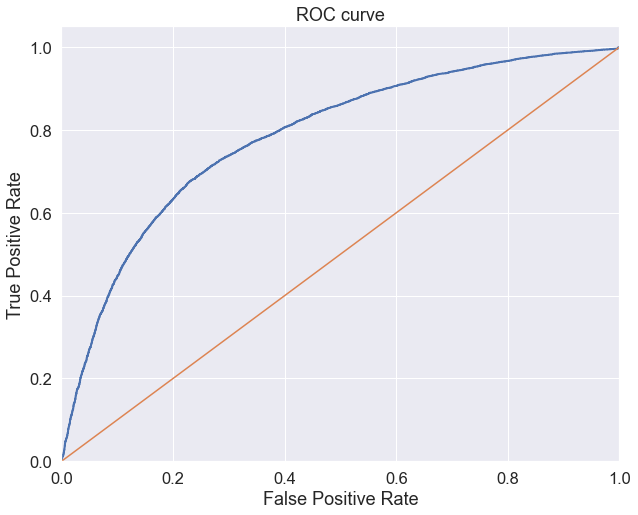

In [11]:
F_class.show_roc_auc(y_test, y_score)

In [12]:
F_class.log_loss_roc_auc (y_test, y_score)

roc auc score: 0.7840347790421852
log loss score: 0.5779604008230663


In [13]:
roc_auc_list = []
roc_auc_list.append(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1]))
roc_auc_list

[0.7840347790421852]

Посомтрим на матрицу ошибок

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


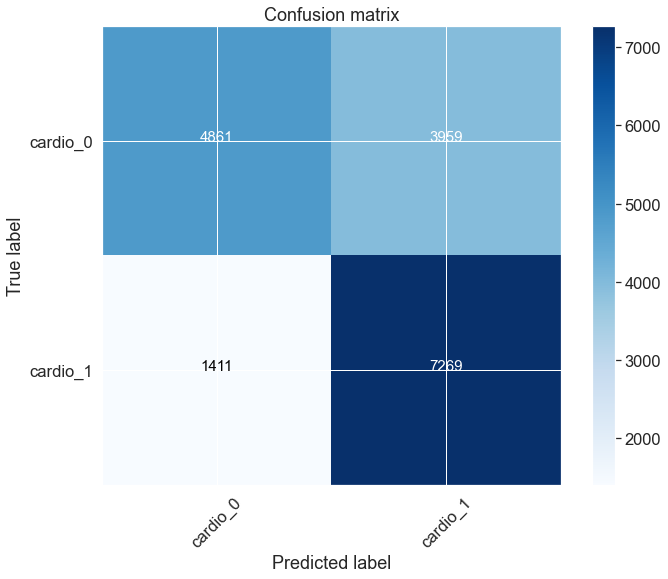

In [14]:
cnf_matrix = F_class.cnf_matrix(y_test, y_score, thresholds)

Посчитаем FPR, TPR

In [15]:
TPR, FPR, TNR = F_class.TPR_FPR_TNR(cnf_matrix)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

False Positive Rate довольно высокий ~ 0.45.

Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы

Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов (какое количество FP мы можем допустить)

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

### Ссылки

1. https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
2. https://en.wikipedia.org/wiki/Receiver_operating_characteristic

Links  
seaborn (визуализация)  
1-2  
обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта  
при обучении моделей обязательно использовать кроссвалидацию

In [16]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Запустим RandomForestClassifier

In [17]:
classifier2 = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=20)),
])


#запустим кросс-валидацию
cv_scores2 = cross_val_score(classifier2, X_train, y_train, cv=16, scoring='roc_auc')
cv_score2 = np.mean(cv_scores2)
cv_score_std2 = np.std(cv_scores2)
print('CV score is {}+-{}'.format(cv_score2, cv_score_std2))

#обучим пайплайн на всем тренировочном датасете
classifier2.fit(X_train, y_train)
y_score2 = classifier2.predict_proba(X_test)[:, 1]

CV score is 0.7920172409634697+-0.007068217748312265


In [18]:
F_class = Functions()

In [19]:
thresholds2, fscore2, precision2, recall2 = F_class.threshold_f_score_precision_recall (y_test.values, y_score2)

Best Threshold=0.356399, F-Score=0.732, Precision=0.661, Recall=0.819


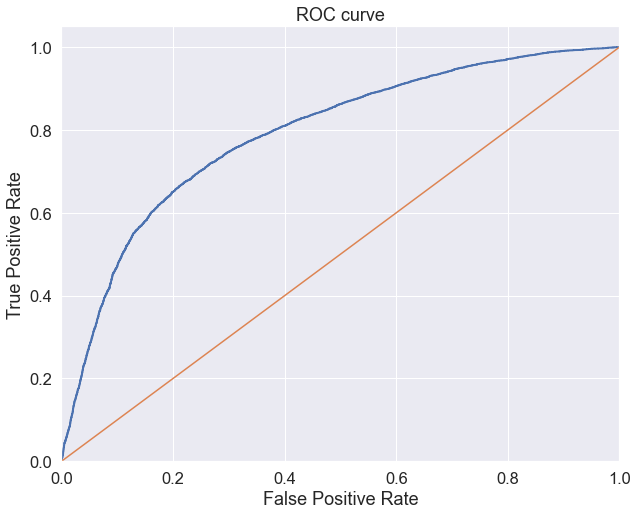

In [20]:
F_class.show_roc_auc(y_test, y_score2)

In [21]:
F_class.log_loss_roc_auc (y_test, y_score2)

roc auc score: 0.7904093127266267
log loss score: 0.5554747434878547


In [22]:
roc_auc_list.append(roc_auc_score(y_true=y_test, y_score=classifier2.predict_proba(X_test)[:,1]))

In [23]:
roc_auc_list

[0.7840347790421852, 0.7904093127266267]

Confusion matrix, without normalization
[[5178 3642]
 [1572 7108]]


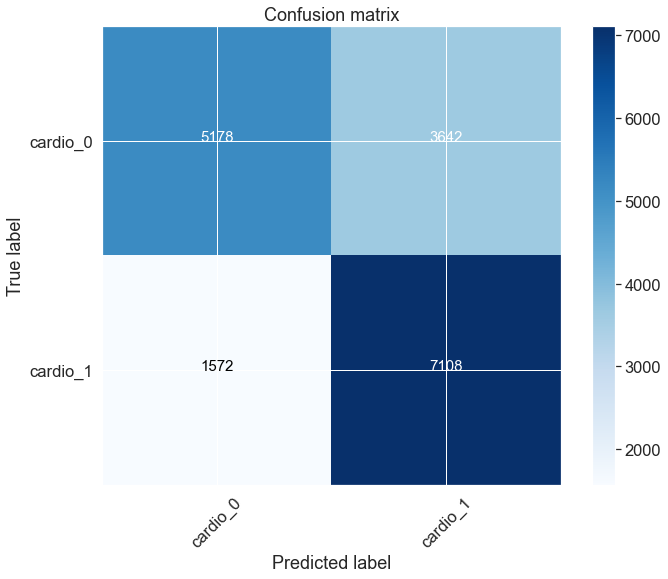

In [24]:
cnf_matrix = F_class.cnf_matrix(y_test, y_score2, thresholds2)

In [25]:
TPR2, FPR2, TNR2 = F_class.TPR_FPR_TNR(cnf_matrix)
TPR2, FPR2, TNR2

(0.8188940092165898, 0.4129251700680272, 0.5870748299319728)

Запустим GradientBoostingClassifier

In [26]:
classifier3 = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier()),
])


#запустим кросс-валидацию
cv_scores3 = cross_val_score(classifier3, X_train, y_train, cv=16, scoring='roc_auc')
cv_score3 = np.mean(cv_scores3)
cv_score_std3 = np.std(cv_scores3)
print('CV score is {}+-{}'.format(cv_score3, cv_score_std3))

#обучим пайплайн на всем тренировочном датасете
classifier3.fit(X_train, y_train)
y_score3 = classifier3.predict_proba(X_test)[:, 1]

CV score is 0.8025163765961227+-0.007069793049383978


In [27]:
F_class = Functions()

In [28]:
thresholds3, fscore3, precision3, recall3 = F_class.threshold_f_score_precision_recall (y_test.values, y_score3)

Best Threshold=0.394947, F-Score=0.740, Precision=0.698, Recall=0.788


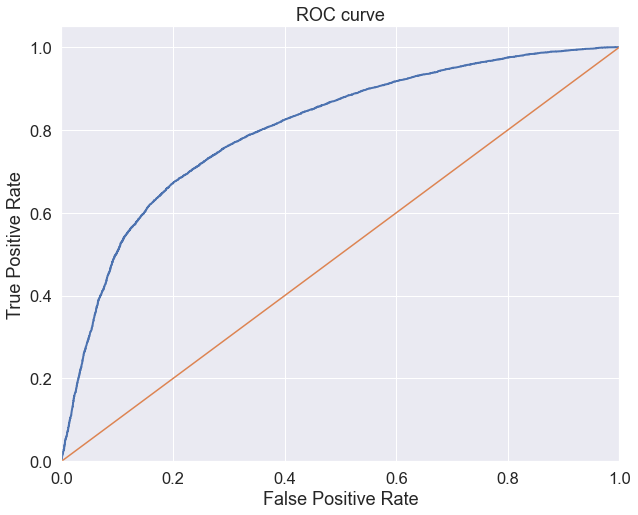

In [29]:
F_class.show_roc_auc(y_test, y_score3)

In [30]:
F_class.log_loss_roc_auc (y_test, y_score3)

roc auc score: 0.8026154294282998
log loss score: 0.5397458066671044


In [31]:
roc_auc_list.append(roc_auc_score(y_true=y_test, y_score=classifier3.predict_proba(X_test)[:,1]))

In [32]:
roc_auc_list

[0.7840347790421852, 0.7904093127266267, 0.8026154294282998]

Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


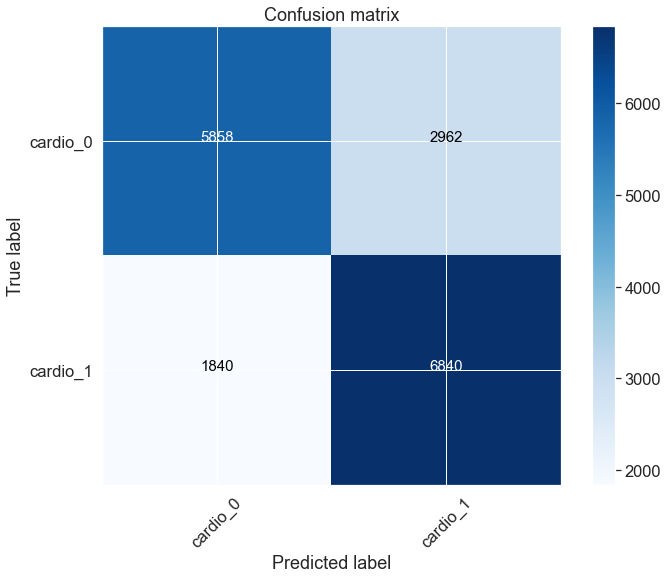

In [33]:
cnf_matrix = F_class.cnf_matrix(y_test, y_score3, thresholds3)

In [34]:
TPR3, FPR3, TNR3 = F_class.TPR_FPR_TNR(cnf_matrix)
TPR3, FPR3, TNR3

(0.7880184331797235, 0.33582766439909295, 0.664172335600907)

3.
вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

In [35]:
metric_table = pd.DataFrame({
                      'CV_score':[cv_score, cv_score2, cv_score3],
                      'Best Threshold':[thresholds, thresholds2, thresholds3], 
                      'F-Score':[fscore, fscore2, fscore3], 
                      'Precision':[precision, precision2, precision3], 
                      'Recall':[recall,recall2, recall3], 
                      'Specificity':[1-FPR, 1-FPR2, 1-FPR3],
                      'ROC AUC':roc_auc_list,
                      'TPR': [TPR, TPR2, TPR3],
                      'FPR': [FPR, FPR2, FPR3],
                      'TNR': [TNR, TNR2, TNR3],
                      'G-Means': [np.sqrt(TPR*(1-FPR)), np.sqrt(TPR2*(1-FPR2)),np.sqrt(TPR3*(1-FPR3))  ] })
metric_table.index = ['LogisticRegression','RandomForestClassifier', 'GradientBoostingClassifier']
metric_table.round(3)

,CV_score,Best Threshold,F-Score,Precision,Recall,Specificity,ROC AUC,TPR,FPR,TNR,G-Means
LogisticRegression,0.787,0.387,0.730,0.647,0.838,0.551,0.784,0.837,0.449,0.551,0.679
RandomForestClassifier,0.792,0.356,0.732,0.661,0.819,0.587,0.790,0.819,0.413,0.587,0.693
GradientBoostingClassifier,0.803,0.395,0.740,0.698,0.788,0.664,0.803,0.788,0.336,0.664,0.723



4.
сделать выводы о том, какая модель справилась с задачей лучше других  
Показатели показывают наилучший результат в модели GradientBoostingClassifier
Но эта модель не может быть оптимальной в нашем случае так как в медицине показатели Recall играет ключевую роль
По этой причине я предложил бы понизить порог GradientBoostingClassifier либо использовать LogisticRegression